Lets load the important libraries

In [1]:

# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import tarfile
import os
import time

from pyspark.sql import Row
%matplotlib inline
import pandas as pd
from pyspark.sql.types import *

import plotly.plotly as py
from plotly.graph_objs import *
import requests
requests.packages.urllib3.disable_warnings()

pd.options.display.mpl_style = 'default'

In [2]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import *

df = sqlContext.read.load('churn-bigml-80.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')


numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] =='double']
categorical_features=[t[0] for t in df.dtypes if t[1] == 'string']

df=df.withColumn("Churn",df.Churn.cast("int").alias("Churn"))

#df.select(numeric_features).describe().toPandas().transpose()

#df.select(categorical_features).describe().show()


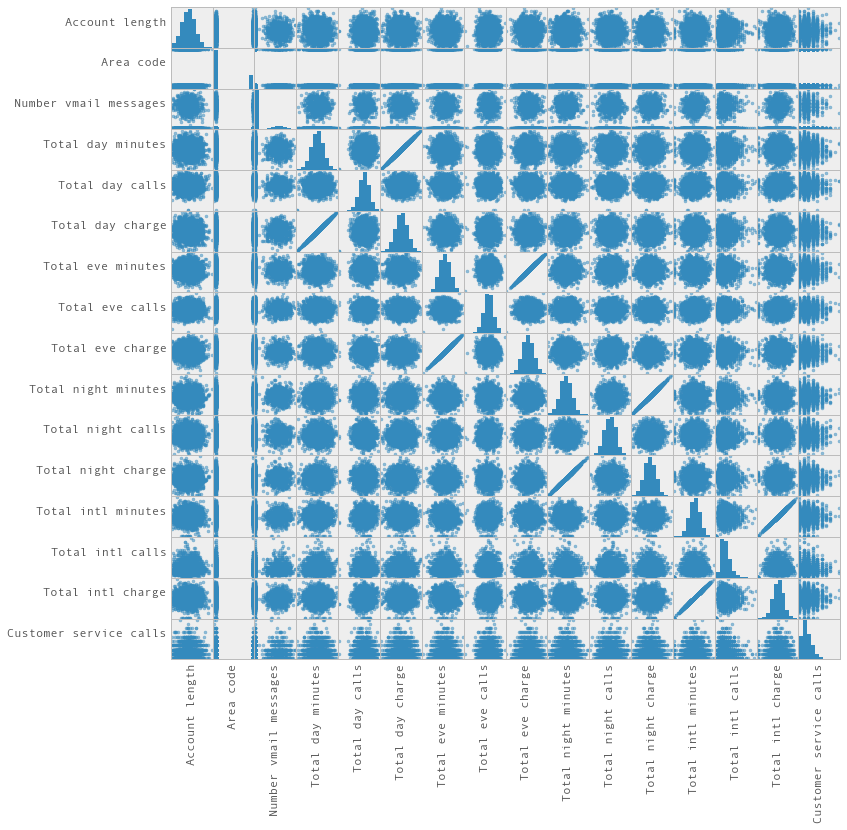

In [3]:

#sampled_data = CV_data.select(numeric_features).sample(False, 0.10).toPandas()
sampled_data = df.select(numeric_features).toPandas()


axs = pd.scatter_matrix(sampled_data, figsize=(12, 12));

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [5]:
###One-Hot Encoding
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier as RF
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
import functools

column_vec_in = categorical_features
column_vec_out = ["_" + feature for feature in column_vec_in]
 
indexers = [StringIndexer(inputCol=x, outputCol=x+'_tmp')
            for x in column_vec_in ]
 
encoders = [OneHotEncoder(dropLast=False, inputCol=x+"_tmp", outputCol=y)
for x,y in zip(column_vec_in, column_vec_out)]
tmp = [[i,j] for i,j in zip(indexers, encoders)]
tmp = [i for sublist in tmp for i in sublist]


In [6]:
cols_now=numeric_features+column_vec_out 
assembler_features = VectorAssembler(inputCols=cols_now, outputCol='features')
labelIndexer = StringIndexer(inputCol='Churn', outputCol="label")
tmp += [assembler_features, labelIndexer]
pipeline = Pipeline(stages=tmp)

In [7]:
allData = pipeline.fit(df).transform(df)
allData.cache()
trainingData, testData = allData.randomSplit([0.8,0.2], seed=0) # need to ensure same split for each time
print("Distribution of Pos and Neg in trainingData is: ", trainingData.groupBy("label").count().take(3))
rf = RF(labelCol='label', featuresCol='features',numTrees=200)
fit = rf.fit(trainingData)
transformed = fit.transform(testData)

predictions = fit.transform(testData)
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)


Distribution of Pos and Neg in trainingData is:  [Row(label=0.0, count=1844), Row(label=1.0, count=290)]


0.9026615254396669

In [8]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = transformed.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is (@numTrees=200): ", metrics.areaUnderROC)

The ROC score is (@numTrees=200):  0.9026615254396687


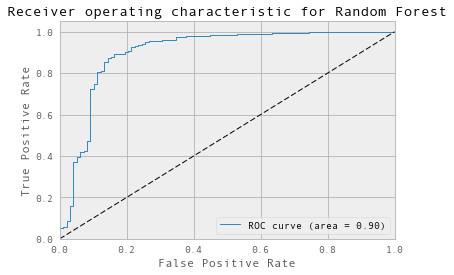

In [9]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Random Forest')
plt.legend(loc="lower right")
plt.show()

In [10]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(trainingData)
transformed = lrModel.transform(testData)


In [11]:
results = transformed.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score for Logistic Regression is: ", metrics.areaUnderROC)

The ROC score for Logistic Regression is:  0.7865136838145398


In [12]:
predictions = lrModel.transform(testData)
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)


0.78651368381454

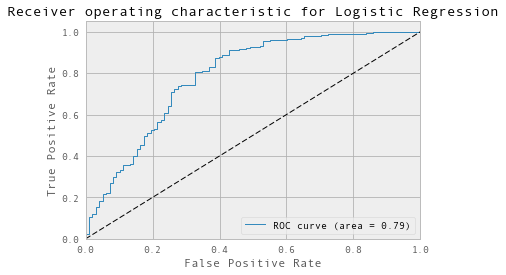

In [13]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.78651368381454

In [ ]:
#TODO: get the ROC plotting in a function
#make a function for one hot encoding as well
# Explore the data, distributions of different columns, correlations, plot correlations
# Make gradient boosting tree as well
# try to do the same example on credit approval ratings, will be difficult. 
# bonus points for data preparation in spark for credict approval ratings
# upload the directory on github
#finish the scatter plot and comeout with a different plot.